In [5]:
pip install pandas numpy matplotlib seaborn scikit-learn nltk

Note: you may need to restart the kernel to use updated packages.


Dataset shape: (2000, 2)
Class distribution:
label
ham     1000
spam    1000
Name: count, dtype: int64

Training multiple models...

Model Performance Comparison:
naive_bayes: Accuracy=1.0000, AUC=1.0000
random_forest: Accuracy=1.0000, AUC=1.0000
svm: Accuracy=1.0000, AUC=1.0000
logistic_regression: Accuracy=1.0000, AUC=1.0000

Performing hyperparameter tuning...
naive_bayes CV Score: 1.0000 (+/- 0.0000)
random_forest CV Score: 1.0000 (+/- 0.0000)
logistic_regression CV Score: 1.0000 (+/- 0.0000)

Final Model Evaluation on Test Set:
Test Accuracy: 1.0000
Test AUC Score: 1.0000

Classification Report:
              precision    recall  f1-score   support

         Ham       1.00      1.00      1.00       200
        Spam       1.00      1.00      1.00       200

    accuracy                           1.00       400
   macro avg       1.00      1.00      1.00       400
weighted avg       1.00      1.00      1.00       400



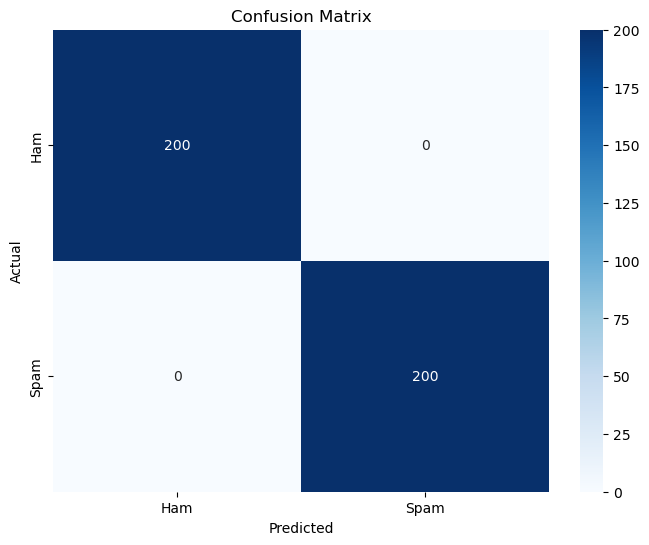


Predicting sample emails:
Email: 'Congratulations! You have won $1000000! Click here...'
Prediction: spam (Spam Probability: 1.0000)
--------------------------------------------------------------------------------
Email: 'Meeting tomorrow at 3 PM in the conference room...'
Prediction: ham (Spam Probability: 0.0000)
--------------------------------------------------------------------------------
Email: 'FREE MONEY! No strings attached! Act now!...'
Prediction: spam (Spam Probability: 0.9943)
--------------------------------------------------------------------------------
Email: 'Please review the quarterly financial report attac...'
Prediction: ham (Spam Probability: 0.0000)
--------------------------------------------------------------------------------
Email: 'Hot singles want to meet you! Click here!...'
Prediction: spam (Spam Probability: 1.0000)
--------------------------------------------------------------------------------


In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
from sklearn.pipeline import Pipeline
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

class SpamDetector:
    def __init__(self):
        self.models = {
            'naive_bayes': MultinomialNB(),
            'random_forest': RandomForestClassifier(n_estimators=100, random_state=42),
            'svm': SVC(probability=True, random_state=42),
            'logistic_regression': LogisticRegression(random_state=42, max_iter=1000)
        }
        self.best_model = None
        self.vectorizer = TfidfVectorizer(max_features=5000, stop_words='english', 
                                        ngram_range=(1, 2), min_df=2, max_df=0.95)
        
    def load_data(self):
        np.random.seed(42)
        spam_emails = [
            "FREE! Win money now! Click here immediately!",
            "Urgent: Your account will be suspended. Verify now!",
            "CONGRATULATIONS! You've won $1000000! Claim now!",
            "Limited time offer! Buy now and save 90%!",
            "Nigerian prince needs your help. Large reward!",
            "Viagra pills 50% off! No prescription needed!",
            "Make money fast working from home! $5000/week!",
            "Your credit score increased! Apply for loan now!",
            "Hot singles in your area want to meet you!",
            "Lose 20 pounds in 2 weeks! Miracle diet!",
            "Act now! Limited time casino bonus!",
            "Free iPhone! Just pay shipping and handling!",
            "Guaranteed loan approval! Bad credit OK!",
            "Work from home! Earn $200/hour! No experience!",
            "Free trial! Cancel anytime! (Hidden fees apply)",
            "Enlarge your... confidence! Special offer!",
            "Tax refund available! Click to claim $2000!",
            "Urgent: Security alert! Update your password!",
            "Free gift card! Complete survey to claim!",
            "Investment opportunity! Double your money!"
        ] * 50
        
        ham_emails = [
            "Meeting scheduled for tomorrow at 2 PM in conference room",
            "Thanks for your presentation yesterday. Great work!",
            "Reminder: Project deadline is next Friday",
            "Please review the attached quarterly report",
            "Team lunch on Thursday. Please RSVP by Wednesday",
            "Your order has been shipped and will arrive Monday",
            "Monthly newsletter: Company updates and achievements",
            "Invoice #12345 is due on the 15th of this month",
            "Welcome to our new team member Sarah Johnson",
            "System maintenance scheduled for this weekend",
            "Conference call notes from today's client meeting",
            "Please submit your timesheet by end of day",
            "Happy birthday! Hope you have a wonderful day",
            "Reminder to complete your annual performance review",
            "New policy update regarding remote work guidelines",
            "Thank you for attending today's training session",
            "Please find attached the meeting minutes from yesterday",
            "Your subscription renewal is due next month",
            "Weather alert: Snow expected tomorrow morning",
            "Library books are due for return this Friday"
        ] * 50
        
        emails = spam_emails + ham_emails
        labels = ['spam'] * len(spam_emails) + ['ham'] * len(ham_emails)
        
        combined = list(zip(emails, labels))
        np.random.shuffle(combined)
        emails, labels = zip(*combined)
        
        return pd.DataFrame({'email': emails, 'label': labels})
    
    def preprocess_data(self, df):
        df['email'] = df['email'].str.lower()
        df['email'] = df['email'].str.replace(r'[^\w\s]', ' ', regex=True)
        df['email'] = df['email'].str.replace(r'\s+', ' ', regex=True)
        df['label_encoded'] = df['label'].map({'ham': 0, 'spam': 1})
        return df
    
    def train_models(self, X_train, y_train, X_val, y_val):
        results = {}
        
        for name, model in self.models.items():
            pipeline = Pipeline([
                ('tfidf', self.vectorizer),
                ('classifier', model)
            ])
            
            pipeline.fit(X_train, y_train)
            y_pred = pipeline.predict(X_val)
            y_prob = pipeline.predict_proba(X_val)[:, 1]
            
            accuracy = accuracy_score(y_val, y_pred)
            auc_score = roc_auc_score(y_val, y_prob)
            
            results[name] = {
                'model': pipeline,
                'accuracy': accuracy,
                'auc': auc_score,
                'predictions': y_pred,
                'probabilities': y_prob
            }
        
        best_model_name = max(results.keys(), key=lambda k: results[k]['auc'])
        self.best_model = results[best_model_name]['model']
        
        return results
    
    def hyperparameter_tuning(self, X_train, y_train):
        param_grids = {
            'naive_bayes': {
                'tfidf__max_features': [3000, 5000, 7000],
                'tfidf__ngram_range': [(1, 1), (1, 2)],
                'classifier__alpha': [0.1, 1.0, 10.0]
            },
            'random_forest': {
                'tfidf__max_features': [3000, 5000],
                'classifier__n_estimators': [50, 100],
                'classifier__max_depth': [10, 20, None]
            },
            'logistic_regression': {
                'tfidf__max_features': [3000, 5000],
                'tfidf__ngram_range': [(1, 1), (1, 2)],
                'classifier__C': [0.1, 1.0, 10.0]
            }
        }
        
        best_models = {}
        
        for name, model in self.models.items():
            if name in param_grids:
                pipeline = Pipeline([
                    ('tfidf', TfidfVectorizer(stop_words='english')),
                    ('classifier', model)
                ])
                
                grid_search = GridSearchCV(
                    pipeline, param_grids[name], 
                    cv=3, scoring='roc_auc', n_jobs=-1
                )
                
                grid_search.fit(X_train, y_train)
                best_models[name] = grid_search.best_estimator_
        
        return best_models
    
    def evaluate_model(self, model, X_test, y_test):
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:, 1]
        
        accuracy = accuracy_score(y_test, y_pred)
        auc_score = roc_auc_score(y_test, y_prob)
        
        print(f"Test Accuracy: {accuracy:.4f}")
        print(f"Test AUC Score: {auc_score:.4f}")
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred, target_names=['Ham', 'Spam']))
        
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                   xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
        plt.title('Confusion Matrix')
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        plt.show()
        
        return accuracy, auc_score
    
    def predict_emails(self, emails):
        if self.best_model is None:
            raise ValueError("Model not trained yet")
        
        predictions = self.best_model.predict(emails)
        probabilities = self.best_model.predict_proba(emails)
        
        results = []
        for i, email in enumerate(emails):
            pred_label = 'spam' if predictions[i] == 1 else 'ham'
            spam_prob = probabilities[i][1]
            results.append({
                'email': email,
                'prediction': pred_label,
                'spam_probability': spam_prob
            })
        
        return results

def main():
    detector = SpamDetector()
    
    df = detector.load_data()
    print(f"Dataset shape: {df.shape}")
    print(f"Class distribution:\n{df['label'].value_counts()}")
    
    df = detector.preprocess_data(df)
    
    X = df['email']
    y = df['label_encoded']
    
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, test_size=0.4, random_state=42, stratify=y
    )
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
    )
    
    print("\nTraining multiple models...")
    results = detector.train_models(X_train, y_train, X_val, y_val)
    
    print("\nModel Performance Comparison:")
    for name, result in results.items():
        print(f"{name}: Accuracy={result['accuracy']:.4f}, AUC={result['auc']:.4f}")
    
    print("\nPerforming hyperparameter tuning...")
    tuned_models = detector.hyperparameter_tuning(X_train, y_train)
    
    best_tuned_model = None
    best_score = 0
    
    for name, model in tuned_models.items():
        cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc')
        mean_score = cv_scores.mean()
        print(f"{name} CV Score: {mean_score:.4f} (+/- {cv_scores.std() * 2:.4f})")
        
        if mean_score > best_score:
            best_score = mean_score
            best_tuned_model = model
    
    detector.best_model = best_tuned_model
    
    print("\nFinal Model Evaluation on Test Set:")
    detector.evaluate_model(detector.best_model, X_test, y_test)
    
    test_emails = [
        "Congratulations! You have won $1000000! Click here to claim now!",
        "Meeting tomorrow at 3 PM in the conference room",
        "FREE MONEY! No strings attached! Act now!",
        "Please review the quarterly financial report attached",
        "Hot singles want to meet you! Click here!"
    ]
    
    print("\nPredicting sample emails:")
    predictions = detector.predict_emails(test_emails)
    
    for pred in predictions:
        print(f"Email: '{pred['email'][:50]}...'")
        print(f"Prediction: {pred['prediction']} (Spam Probability: {pred['spam_probability']:.4f})")
        print("-" * 80)

if __name__ == "__main__":
    main()